# Naive Bayes news

In [12]:
import json
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
%pip install -U jinja2

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported!")


Note: you may need to restart the kernel to use updated packages.
Libraries imported!


In [3]:
file_path = 'news/labeled_1000_with_sport.json'

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Number of articles: {len(data)}")

Number of articles: 7000


In [4]:
texts = []
labels = []

for article in data:
    texts.append(article['text'])
    labels.append(article['label'])

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {len(X_train)} articles")
print(f"Test set: {len(X_test)} articles")
print(f"Categories in training set: {Counter(y_train)}")


Training set: 5600 articles
Test set: 1400 articles
Categories in training set: Counter({'World': 800, 'Health': 800, 'Politics': 800, 'sport': 800, 'Business': 800, 'Culture': 800, 'Technology': 800})


In [ ]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(
        lowercase=True,
        token_pattern=r'\b[a-z]+\b',
        min_df=2,
        max_features=10000
    )),
    ('classifier', MultinomialNB(alpha=1.0))
])

classifier.fit(X_train, y_train)

print("✓ Trained!")
print(f"Number of features (words): {len(classifier.named_steps['vectorizer'].vocabulary_)}")


NAIVE BAYES CLASSIFIER FROM SCIKIT-LEARN

Training classifier...
✓ Trained!
Number of features (words): 10000


In [18]:
predictions = classifier.predict(X_test)

accuracy = accuracy_score(y_test, predictions) * 100

report = classification_report(y_test, predictions, output_dict=True, zero_division=0)

results = []
for label in sorted(report.keys()):
    if label not in ['accuracy', 'macro avg', 'weighted avg']:
        results.append({
            'Category': label,
            'Precision': f"{report[label]['precision']:.4f}",
            'Recall': f"{report[label]['recall']:.4f}",
            'F1-Score': f"{report[label]['f1-score']:.4f}"
        })

df = pd.DataFrame(results)
df['Precision'] = pd.to_numeric(df['Precision'])
df['Recall'] = pd.to_numeric(df['Recall'])
df['F1-Score'] = pd.to_numeric(df['F1-Score'])

styled_df = df.style.format({
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}'
}).background_gradient(subset=['Precision', 'Recall', 'F1-Score'], cmap='YlGnBu', vmin=0, vmax=1).set_caption(f'Overall Accuracy: {accuracy:.2f}%').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

display(styled_df)


,Category,Precision,Recall,F1-Score
0,Business,0.8290,0.8000,0.8142
1,Culture,0.7773,0.8900,0.8298
2,Health,0.8312,0.9600,0.8910
3,Politics,0.9430,0.7450,0.8324
4,Technology,0.7746,0.8250,0.7990
5,World,0.9314,0.8150,0.8693
6,sport,0.9801,0.9850,0.9825


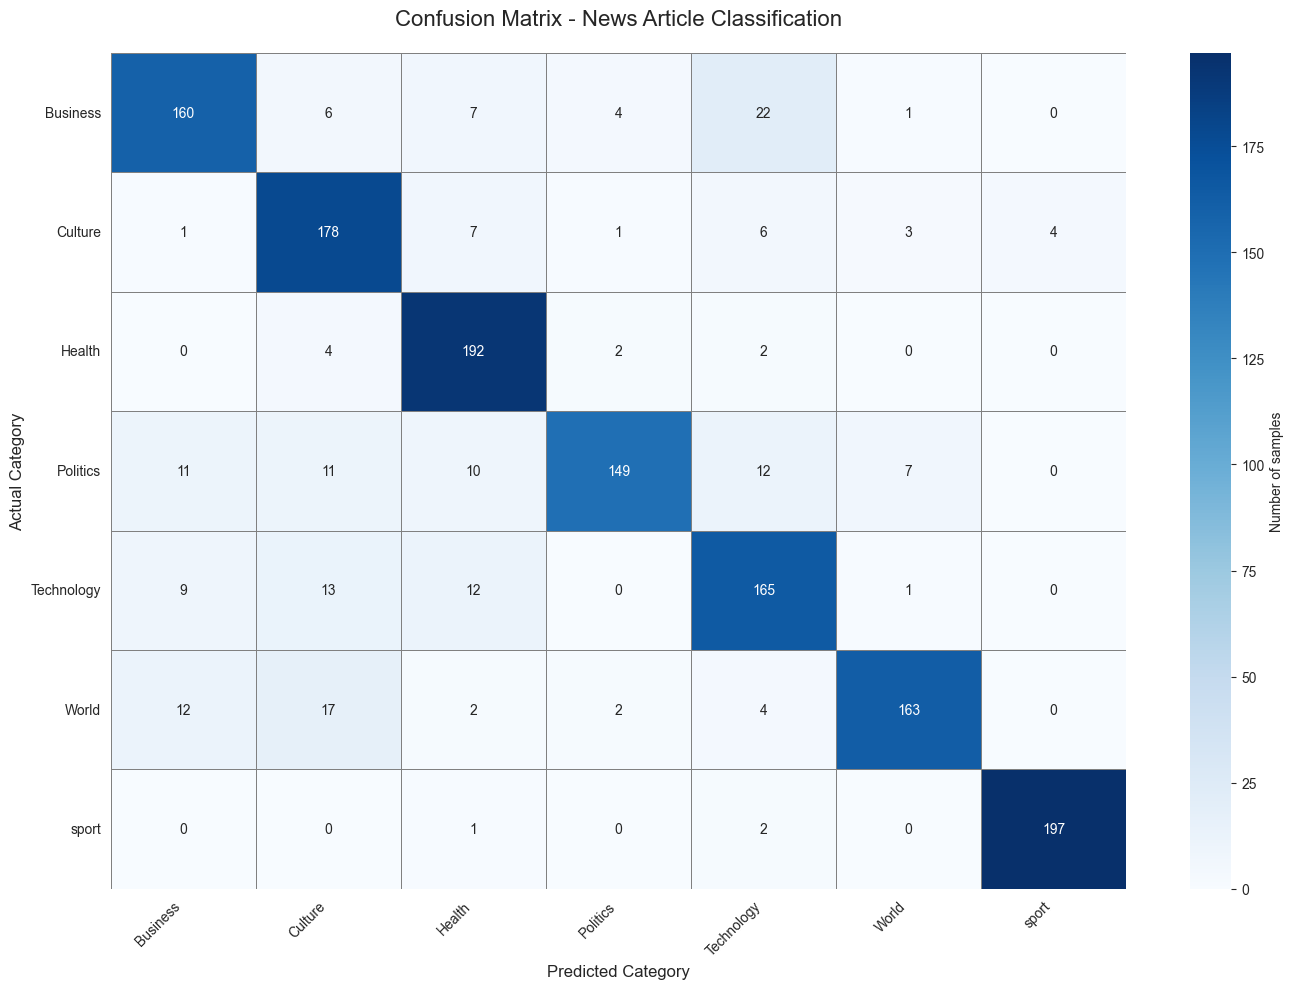

In [17]:
from sklearn.utils.multiclass import unique_labels

labels = list(unique_labels(y_test, predictions))
cm = confusion_matrix(y_test, predictions, labels=labels)
categories = labels

plt.figure(figsize=(14, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=categories,
    yticklabels=categories,
    cbar_kws={'label': 'Number of samples'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Confusion Matrix - News Article Classification', fontsize=16, pad=20)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('Actual Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

